In [13]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1,"/core/github/cryptoderiv-quant-lib")

from cdcqr.analytics.derivatives.vol_fitting.smoothing.utils import cumsum_getTEvents, fit_fun2
from scipy.interpolate import interp1d

from cryptoderiv_quantlib import VolModels
from cryptoderiv_quantlib import VolCurve, VolSurface, StickyOptions

from cdcqr.analytics.derivatives.vol_fitting.smoothing import kalman_filter as kf

In [14]:
from importlib import reload

In [15]:
MODEL_TO_TEST = "parabolic_linear6"
model = VolModels.vol_model(MODEL_TO_TEST)

In [34]:
df = pd.read_pickle('/core/data/fitted_vol_1.pkl')

### 1) use vol_atm --> find rolling mean and std --> apply cusum

In [235]:
print(df.shape)
print(df.columns)
lbw = 50

(4695, 34)
Index(['t', 'expire', 'df', 'localcurve', 'currcurve', 'err1', 'err2',
       'currerr', 'changecurvecounter', 'localATM', 'currATM',
       'localskew_left', 'currskew_left', 'ewmskew_left', 'localskew_right',
       'currskew_right', 'ewmskew_right', 'localconv_left', 'currconv_left',
       'ewmconv_left', 'localconv_right', 'currconv_right', 'ewmconv_right',
       'localrightwing', 'currrightwing', 'ewmrightwing', 'localleftwing',
       'currleftwing', 'ewmleftwing', 'localvol_atm', 'currvol_atm',
       'ewmvol_atm', 'ewm_x', 'ewmerr'],
      dtype='object')


In [236]:
df['ma_localvol_atm'] = df['localvol_atm'].rolling(lbw).mean()
df['rstd_localvol_atm'] = df['localvol_atm'].rolling(lbw).std()
df['zscore_localvol_atm'] = (df['localvol_atm']-df['ma_localvol_atm'])/df['rstd_localvol_atm']

### 1.1) test a range of threshold for CUMSUM algo

In [237]:
h2events_ratio = {}
n = df.shape[0] - lbw
for h in np.linspace(0.5, 5, 100):
    m = len(cumsum_getTEvents(df['zscore_localvol_atm'], h))
    r = m/n
    h2events_ratio[h] = r

<AxesSubplot:xlabel='cumsum_threshold'>

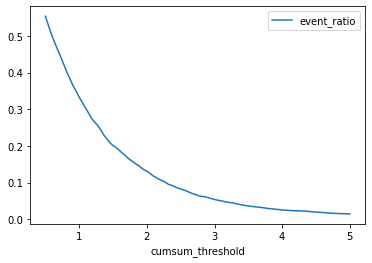

In [238]:
df_h2events_ratio = pd.DataFrame(h2events_ratio, index=[0]).T.reset_index()
df_h2events_ratio.columns = ['cumsum_threshold', 'event_ratio']
df_h2events_ratio = df_h2events_ratio.set_index('cumsum_threshold')
df_h2events_ratio.plot()

#### 1.2) take h = 3 for example

In [239]:
h = 3
interp1d(df_h2events_ratio.index, df_h2events_ratio['event_ratio'])([3])[0]

0.05403659849300323

In [240]:
cumsum_event_index = cumsum_getTEvents(df['zscore_localvol_atm'], h)
df['cumsum_event'] = False
df.loc[cumsum_event_index, ['cumsum_event']]=True
df['cumsum_event'].iloc[0]=True

C:\Users\Wang\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [241]:
df['cumsum_curve'] = df['localcurve']
df['cumsum_curve'] = df['cumsum_curve'].where(df['cumsum_event'], np.nan)
df['cumsum_curve'] = df['cumsum_curve'].ffill()

#### 1.3) apply metric to check is the CUMSUM algo with h = 3 is good or not?

In [242]:
error =  df[['cumsum_curve','df']].apply(lambda x: fit_fun2(*x), axis=1).mean(1)

In [243]:
df.shape

(4695, 39)

In [244]:
display(error.mean())

0.9428090018595959

### 2) at each time t, use the time series of mid iv of each strke = miv = (biv+aiv)/2 --> find the mean and std --> aggregate the z value --> apply cusum (or some variation of this)

In [245]:
df0 = pd.read_pickle('/core/data/vol_smoothing_base_1.pkl')

In [246]:
display(df0.head(2))
display(df.head(2))

,tm,expire,strike,ty,s,aiv,biv,vega,params
0,1638316800000,1640937600000,22000.0,-1,57406.67,1.4606,1.3408,2.40936,{}
1,1638316800000,1640937600000,24000.0,-1,57439.75,1.3375,1.2269,2.60587,{}


,t,expire,df,localcurve,currcurve,err1,err2,currerr,changecurvecounter,localATM,...,localvol_atm,currvol_atm,ewmvol_atm,ewm_x,ewmerr,ma_localvol_atm,rstd_localvol_atm,zscore_localvol_atm,cumsum_event,cumsum_curve
0,1638316800000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001184,0.001184,0.001184,0,0.799385,...,0.799385,0.799385,0.799385,"[0.05706715921572881, -0.025751727294213003, 0...",0.001184,NaN,NaN,NaN,True,<cryptoderiv_quantlib.volatility.data_objects....
1,1638316860000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001212,0.001223,0.001223,0,0.801711,...,0.801711,0.799385,0.800609,"[0.05493853329443952, -0.02816033204865347, 0....",0.001209,NaN,NaN,NaN,False,<cryptoderiv_quantlib.volatility.data_objects....


In [256]:
df1 = pd.merge(left=df, right=df0[['tm','aiv','biv',]], left_on=['t'], right_on=['tm'], how='left').groupby('t').first().reset_index()

In [258]:
df1['miv'] = 0.5*(df1['biv'] + df1['aiv'])

In [259]:
df1['ma_miv'] = df1['miv'].rolling(lbw).mean()
df1['rstd_miv'] = df1['miv'].rolling(lbw).std()
df1['zscore_miv'] = (df1['miv']-df1['ma_miv'])/df1['rstd_miv']

In [260]:
cumsum_event_index = cumsum_getTEvents(df1['zscore_miv'], h)
df1['cumsum_event'] = False
df1.loc[cumsum_event_index, ['cumsum_event']]=True
df1['cumsum_event'].iloc[0]=True

C:\Users\Wang\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [261]:
df1['cumsum_curve'] = df1['localcurve']
df1['cumsum_curve'] = df1['cumsum_curve'].where(df1['cumsum_event'], np.nan)
df1['cumsum_curve'] = df1['cumsum_curve'].ffill()

#### apply metric to check is the CUMSUM algo with h = 3 is good or not?

In [262]:
error =  df1[['cumsum_curve','df']].apply(lambda x: fit_fun2(*x), axis=1).mean(1)

In [263]:
display(error.mean())

0.9268391680899355

### 3) at each time t, use the spread = aiv - biv as a measure of std (maybe spread = 2 std) --> use miv as the mean --> z value --> aggregate --> apply cusum

In [269]:
df2 = df1.copy()
df2['iv_range'] = df2['biv'] - df2['aiv']
df2['normalized_miv'] = (df2['miv']-df2['ma_miv'])/df2['iv_range']
# try more methods

In [270]:
cumsum_event_index = cumsum_getTEvents(df2['normalized_miv'], h)
df2['cumsum_event'] = False
df2.loc[cumsum_event_index, ['cumsum_event']]=True
df2['cumsum_event'].iloc[0]=True

In [271]:
df2['cumsum_curve'] = df2['localcurve']
df2['cumsum_curve'] = df2['cumsum_curve'].where(df2['cumsum_event'], np.nan)
df2['cumsum_curve'] = df2['cumsum_curve'].ffill()

#### apply metric to check is the CUMSUM algo with h = 3 is good or not?

In [272]:
error2 =  df2[['cumsum_curve','df']].apply(lambda x: fit_fun2(*x), axis=1).mean(1)

In [273]:
error2.mean()

0.4383904663541086

## Kalman filter smoothing

In [98]:
reload(kf)

<module 'cdcqr.analytics.derivatives.vol_fitting.smoothing.kalman_filter' from 'c:\\core\\github\\cdcqr\\cdcqr\\analytics\\derivatives\\vol_fitting\\smoothing\\kalman_filter.py'>

In [99]:
kf.simple_kalman_filter?

Signature: kf.simple_kalman_filter(z, x_prev, sigma1, h_mat, sigma2)
Docstring: <no docstring>
File:      c:\core\github\cdcqr\cdcqr\analytics\derivatives\vol_fitting\smoothing\kalman_filter.py
Type:      function


In [100]:
pre_params = df['localcurve'].iloc[0].params
pre_x = np.array([1, pre_params['skew_left'], pre_params['skew_right'], pre_params['conv_left'], pre_params['conv_right'], pre_params['rightwing'], pre_params['leftwing']])
pre_x

array([ 1.        ,  0.05706716, -0.02575173,  0.01570563,  0.05909604,
        0.16671032,  0.22418722])

In [101]:
df1 = df['df'][1]

In [102]:
kright = 1.5
kleft = -1.5

In [103]:
S = df1['s'].iloc[0]

In [104]:
volATM = interp1d(df1.index, df1['m'])([S])[0]

In [105]:
# observations
z = df1['m'].values

In [106]:
# transformation matrix

df1['col0'] = volATM
df1['col1'] = (df1['logKFtau']<0).astype(int)*kleft
df1['col2'] = (df1['logKFtau']>0).astype(int)*kright
df1['col3'] = (df1['logKFtau']<0).astype(int)*kleft**2
df1['col4'] = (df1['logKFtau']>0).astype(int)*kright**2
df1['col5'] = (df1['logKFtau']>0).astype(int)*(df1['logKFtau']-kright)
df1['col6'] = (df1['logKFtau']<0).astype(int)*(df1['logKFtau']-kleft)

h_mat = df1[['col0','col1','col2','col3','col4','col5','col6']].values

In [107]:
kf.simple_kalman_filter(z, pre_x, 0.01, h_mat, 0.01)

ValueError: operands could not be broadcast together with shapes (7,31) (31,31) 

In [88]:
P_p = filter.A.dot(filter.P).dot(filter.A.T) + filter.Q

AttributeError: 'function' object has no attribute 'A'

In [110]:
    n = 7
    m = np.shape(h_mat)[0]
    sigma1 = 0.01
    sigma2 = 0.01
    filter.x = pre_x
    filter.P = sigma1*np.eye(n)
    filter.A = np.eye(n)
    filter.H = h_mat
    filter.HT = filter.H.T
    filter.Q = sigma2*np.eye(n)

In [115]:
np.shape(filter.HT)

(7, 31)

In [111]:
    # Predict State Forward
    x_p = filter.A.dot(filter.x)
    # Predict Covariance Forward
    P_p = filter.A.dot(filter.P).dot(filter.A.T) + filter.Q
    # Compute Kalman Gain
    S = filter.H.dot(P_p).dot(filter.HT)
    K = P_p.dot(filter.HT)*(1/S)
    # Estimate State
    residual = z - filter.H.dot(x_p)
    filter.x = x_p + K*residual
    # Estimate Covariance
    filter.P = P_p - K.dot(filter.H).dot(P_p)

ValueError: operands could not be broadcast together with shapes (7,31) (31,31) 

In [119]:
display(np.shape(P_p))
display(np.shape(filter.HT))

(7, 7)

(7, 31)

In [123]:
    K = P_p.dot(filter.HT)*(1/S)


ValueError: operands could not be broadcast together with shapes (7,31) (31,31) 